In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import time
import os

In [2]:
torch.cuda.is_available(), torch.version.cuda, torch.cuda.get_device_name()

(True, '12.6', 'NVIDIA T4G')

In [3]:
os.cpu_count()

4

In [4]:
cpu = torch.device('cpu')
cpu

device(type='cpu')

In [5]:
device = torch.device('cuda')
device

device(type='cuda')

In [6]:
torch.manual_seed(8)

In [2]:
"""
SVHN images are already in [0, 1] range and RGB format.

For the transforms, we'll:
1. Covert to tensor
2. Normalize
    a. The first (0.5, 0.5, 0.5) are the means for each RGB channel. The second one are the stdevs for
        each channel.
    b. Normalization works by subtracting 0.5 from each color channel, then dividing by 0.5.
    c. This transforms the original pixel values from [0, 1] to [-1, 1], which centers the data around
        zero, and makes the gradient flow better during training.
"""
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
start = time.perf_counter()

train_dataset = torchvision.datasets.SVHN(
    root='./data', 
    split='train', 
    download=True, 
    transform=transform
)

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

Elapsed time: 2.376173 seconds


In [4]:
start = time.perf_counter()

test_dataset = torchvision.datasets.SVHN(
    root='./data', 
    split='test', 
    download=True, 
    transform=transform,
)

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

Elapsed time: 0.745744 seconds


In [10]:
!du -h

20K	./.ipynb_checkpoints
235M	./data
235M	.


In [5]:
def get_dataset_stats(dataloader, gpu=True):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in dataloader:
        if gpu:
            data = data.to(device)
        
        # Mean over batch, height and width, but not over channels
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    
    return mean, std

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

start = time.perf_counter()

_mean, _std = get_dataset_stats(train_loader, gpu=False)

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

print(_mean, _std)

Elapsed time: 6.969040 seconds
tensor([0.4377, 0.4438, 0.4728]) tensor([0.1980, 0.2010, 0.1970])


In [13]:
# Now set a number of workers for the data loader.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())

start = time.perf_counter()

_mean, _std = get_dataset_stats(train_loader, gpu=False)

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

print(_mean, _std)

Elapsed time: 5.578656 seconds
tensor([0.4377, 0.4438, 0.4728]) tensor([0.1980, 0.2010, 0.1970])


In [14]:
# Now pin the memory.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)

start = time.perf_counter()

_mean, _std = get_dataset_stats(train_loader, gpu=True)

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

print(_mean, _std)

Elapsed time: 11.472917 seconds
tensor([0.4377, 0.4438, 0.4728], device='cuda:0') tensor([0.1980, 0.2010, 0.1970], device='cuda:0')


As mentioned in https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

> It is generally not recommended to return CUDA tensors in multi-process loading because of many subtleties in using CUDA and sharing CUDA tensors in multiprocessing (see CUDA in multiprocessing). Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True), which enables fast data transfer to CUDA-enabled GPUs.

In [15]:
_mean.to(), _mean.to(cpu), _mean.cpu().tolist()

(tensor([0.4377, 0.4438, 0.4728], device='cuda:0'),
 tensor([0.4377, 0.4438, 0.4728]),
 [0.43768176436424255, 0.4437732398509979, 0.4728061556816101])

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=_mean.cpu().tolist(),
        std=_std.cpu().tolist(),
    )
])

In [8]:
train_dataset = torchvision.datasets.SVHN(
    root='./data', 
    split='train', 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.SVHN(
    root='./data', 
    split='test', 
    download=True, 
    transform=transform,
)

In [9]:
# Create dataloaders.
# Note that suffle is set to false for the test dataloader.
# Only 'cas if we want to analyze specific examples that gave incorrect predictions,
# having a deterministic order makes it easier to trace back which examples those were.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Inspect the Data

In [19]:
f'{len(train_dataset)=:_}, {len(test_dataset)=:_}'

'len(train_dataset)=73_257, len(test_dataset)=26_032'

In [55]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f'Image batch shape: {images.shape}')
print(f'Image data type: {images.dtype}')
print()
print(f'Label batch shape: {labels.shape}')
print(f'Label data type: {labels.dtype}')

Image batch shape: torch.Size([64, 3, 32, 32])
Image data type: torch.float32

Label batch shape: torch.Size([64])
Label data type: torch.int64


In [56]:
# Let's see what classes we have and their distribution.
unique_labels, counts = np.unique(train_dataset.labels, return_counts=True)

print('\nLabel distribution in training set:')
for label, count in zip(unique_labels, counts):
    print(f'Label {label}: {count} images ({count/len(train_dataset)*100:.2f}%)')


Label distribution in training set:
Label 0: 4948 images (6.75%)
Label 1: 13861 images (18.92%)
Label 2: 10585 images (14.45%)
Label 3: 8497 images (11.60%)
Label 4: 7458 images (10.18%)
Label 5: 6882 images (9.39%)
Label 6: 5727 images (7.82%)
Label 7: 5595 images (7.64%)
Label 8: 5045 images (6.89%)
Label 9: 4659 images (6.36%)


In [60]:
flattened_imgs = images.view(images.size(0), -1)
print('\nImage statistics:')
print(f'Min pixel value: {flattened_imgs.min().item():.3f}')
print(f'Max pixel value: {flattened_imgs.max().item():.3f}')
print(f'Mean pixel value: {flattened_imgs.mean().item():.3f}')
print(f'Standard deviation: {flattened_imgs.std().item():.3f}')


Image statistics:
Min pixel value: -2.210
Max pixel value: 2.840
Mean pixel value: 0.046
Standard deviation: 0.981


In [63]:
images.shape

torch.Size([64, 3, 32, 32])

In [64]:
help(images.view)

Help on built-in function view:

view(...) method of torch.Tensor instance
    view(*shape) -> Tensor

    Returns a new tensor with the same data as the :attr:`self` tensor but of a
    different :attr:`shape`.

    The returned tensor shares the same data and must have the same number
    of elements, but may have a different size. For a tensor to be viewed, the new
    view size must be compatible with its original size and stride, i.e., each new
    view dimension must either be a subspace of an original dimension, or only span
    across original dimensions :math:`d, d+1, \dots, d+k` that satisfy the following
    contiguity-like condition that :math:`\forall i = d, \dots, d+k-1`,

    .. math::

      \text{stride}[i] = \text{stride}[i+1] \times \text{size}[i+1]

    Otherwise, it will not be possible to view :attr:`self` tensor as :attr:`shape`
    without copying it (e.g., via :meth:`contiguous`). When it is unclear whether a
    :meth:`view` can be performed, it is advisable t

# Looking at the Images

In [10]:
def denormalize(image, mean=0.5, std=0.5):
    """
    Remember that to normalize we do:
        (X - mean) / std

    So now we go backwards:
        (X * std) + mean
    
    Args:
        image: Normalized image tensor or array in range of [-1, 1]
        mean: The mean used in normalization (default 0.5)
        std: The std used in normalization (default 0.5)
    
    Returns:
        Denormalized image in [0, 1] range
    """
    img = (image * std) + mean
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

In [11]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    img = denormalize(npimg)
    plt.imshow(img)
    plt.axis('off')

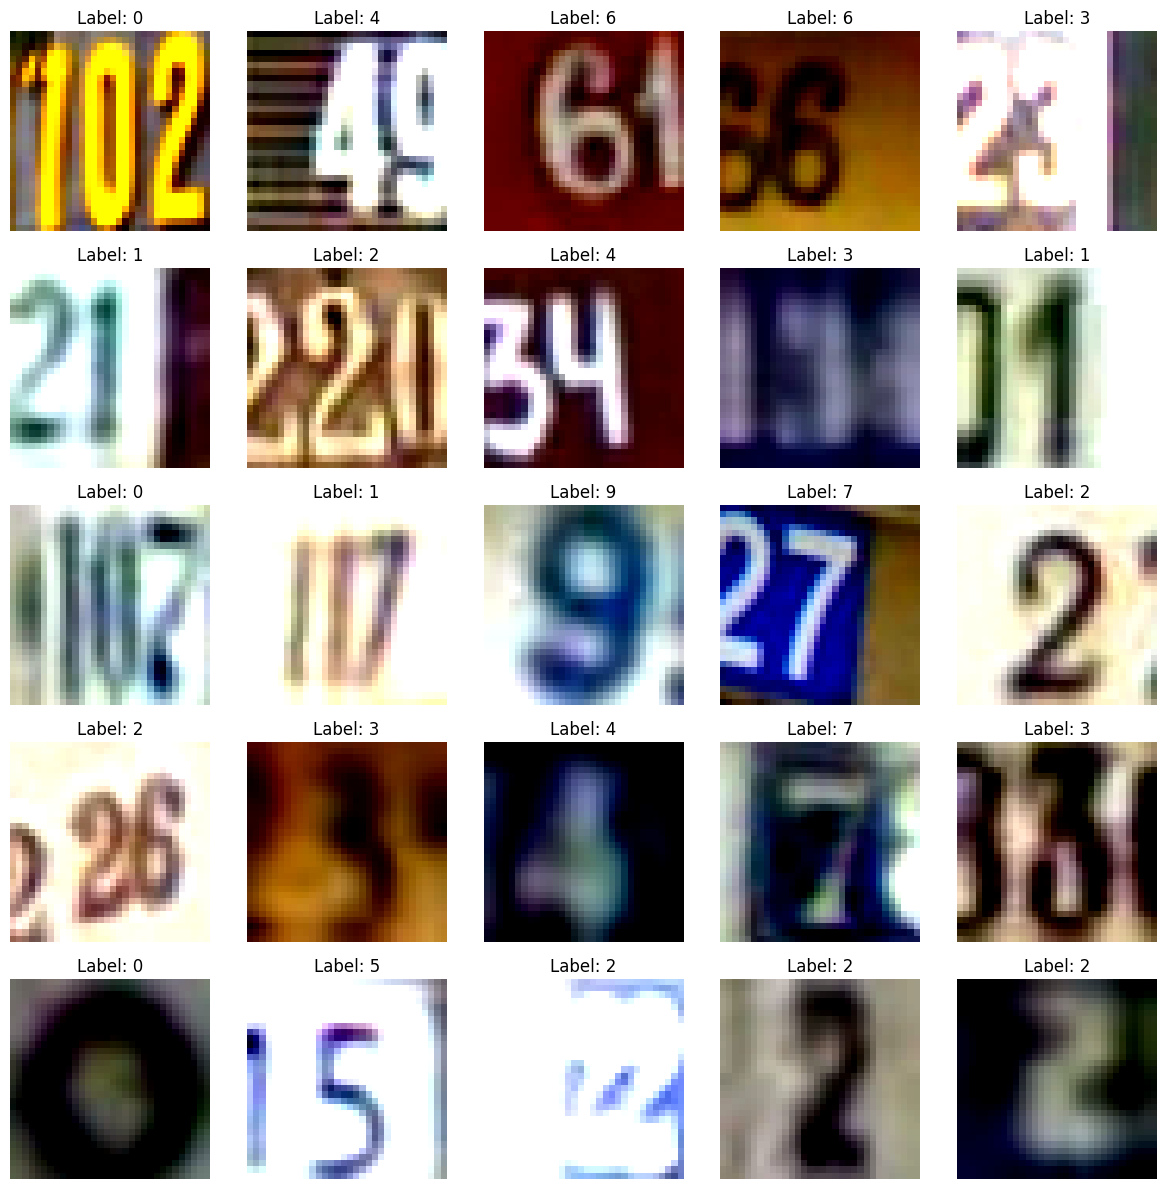

In [12]:
# Get a batch of random images.
indices = torch.randperm(len(train_dataset))[:25]
sample_images = [train_dataset[i][0] for i in indices]
sample_labels = [train_dataset[i][1] for i in indices]

# Create a grid to display them.
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    imshow(sample_images[i])
    plt.title(f"Label: {sample_labels[i]}")
plt.tight_layout()
plt.show()

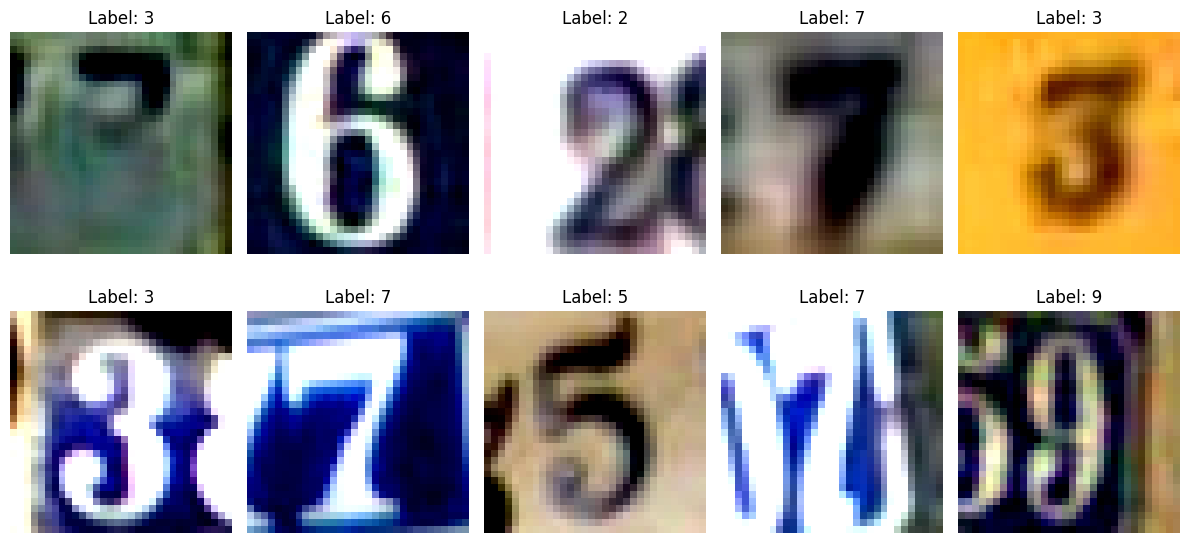

In [19]:
# Get a batch of random images.
indices = torch.randperm(len(train_dataset))[:10]
sample_images = [train_dataset[i][0] for i in indices]
sample_labels = [train_dataset[i][1] for i in indices]

# Create a grid to display them.
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    imshow(sample_images[i])
    plt.title(f"Label: {sample_labels[i]}")
plt.tight_layout()
plt.savefig('svhn_samples.png')
plt.show()

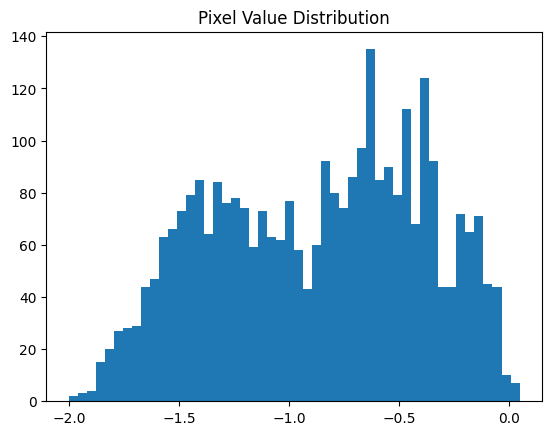

In [65]:
img = sample_images[0]
npimg = img.numpy()
npimg = np.transpose(npimg, (1, 2, 0))
img = denormalize(npimg)

plt.hist(npimg.flatten(), bins=50)
plt.title("Pixel Value Distribution")

plt.show()